# GridWorld Capture the Flag MVP Environment

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
from dueling_dqn_network import DuelingDQNNetwork
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
import utils as ut
import train_dqn as tdqn

from ppo import PPOMemory, ActorNetwork, CriticNetwork, PPOAgent
import train_ppo as tppo

# Check devices
print(f"mps available: {torch.backends.mps.is_available()}")
print(f"mps built: {torch.backends.mps.is_built()}")
print(f"cuda available: {torch.cuda.is_available()}")

mps available: False
mps built: False
cuda available: False


## MVP Environment

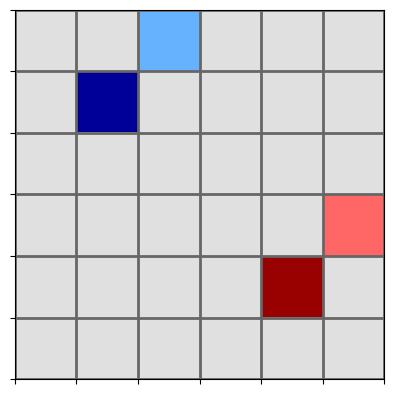

In [2]:
# instantiate environment
env = GridworldCtf(AGENT_CONFIG = {
                        0: {'team':0, 'type':0},
                        1: {'team':1, 'type':0}
                    },
                    GAME_MODE='static',
                    GRID_LEN=6)
env.render()

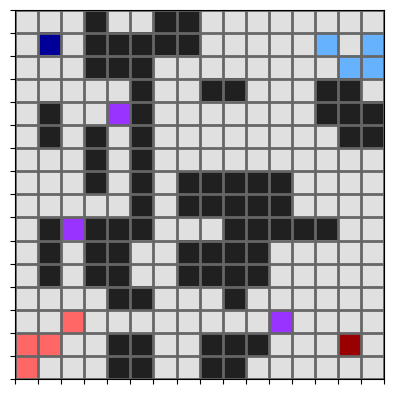

In [3]:
# instantiate environment
env = GridworldCtf(AGENT_CONFIG = {
                        0: {'team':0, 'type':0},
                        1: {'team':1, 'type':0},
                        2: {'team':0, 'type':0},
                        3: {'team':1, 'type':0},
                        4: {'team':0, 'type':0},
                        5: {'team':1, 'type':0},
                        6: {'team':0, 'type':0},
                        7: {'team':1, 'type':0}
                    },
                   GAME_MODE='random',
                   GRID_LEN=16,
                   ENABLE_PICKUPS=True,
                   ENABLE_OBSTACLES=True,
                   MAX_BLOCK_TILE_PCT=0.33,
                   MAX_HEALTH_PICKUP_TILES=3
                   )
env.render()

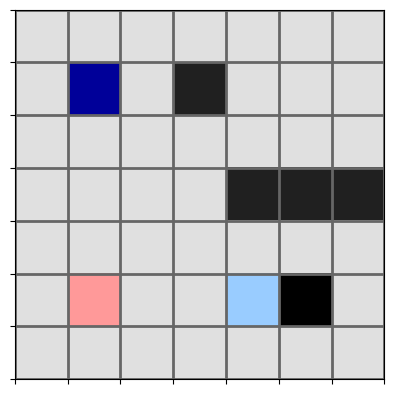

Move 12
reward: -1
flag captures: 0
hp: 2
done: False
Game exited


In [3]:
# playing against random agents
env = GridworldCtf(AGENT_CONFIG = {
                        0: {'team':0, 'type':2},
                        1: {'team':1, 'type':2},
                    },
                   GAME_MODE='random',
                   GRID_LEN=7,
                   ENABLE_OBSTACLES=True)

env.play(player=0, render_ego_state=False)

TypeError: unhashable type: 'numpy.ndarray'

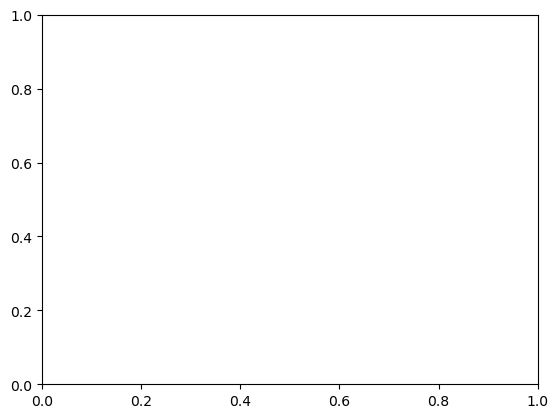

In [4]:
env.render(ego_state_agent=0)

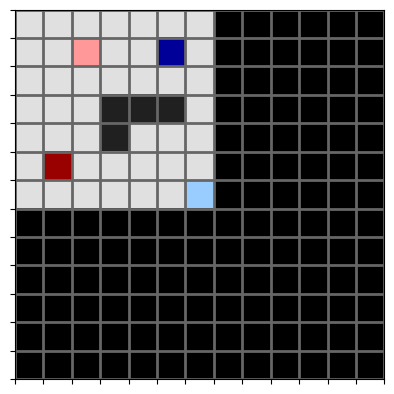

In [18]:
env.render(ego_state_agent=1)

## Deep Q-Network

### Train agents - Flag carriers only

In [19]:
# create environment
env = GridworldCtf(GAME_MODE='static',
                   GRID_LEN=7,
                   N_AGENTS=4)
device = "cpu"

# configure agents
n_actions = 8
n_channels = 1
batch_size = 32
gamma = 0.9
lr = 0.00005
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
use_softmax = True
loss = 'mse'

agent_t1 = DQNAgent(name='dqn_t1',
                    grid_len=env.GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

agent_t2 = DQNAgent(name='dqn_t2',
                    grid_len=env.GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

# train agents
training_metrics = tdqn.train_dqn(env,
                                agent_t1,
                                agent_t2,
                                epochs=1000,
                                batch_size=batch_size,
                                epsilon=epsilon,
                                epsilon_decay=0.999,
                                epsilon_min=0.1,
                                n_random_steps=0,
                                max_steps=1000,
                                learning_skip_steps=1,
                                use_ego_state=False,
                                scale_tiles=False,
                                device=device)

episode: 996                 
total step count: 282910                 
episode step count: 253                 
score: -512                 
average score: -366.2                 
epsilon: 0.3695                 
done count: 996                 
team 1 captures: 1940                 
team 2 captures: 2323


In [17]:
# Save models
agent_t1.save_model()
agent_t2.save_model()

#### Performance metrics

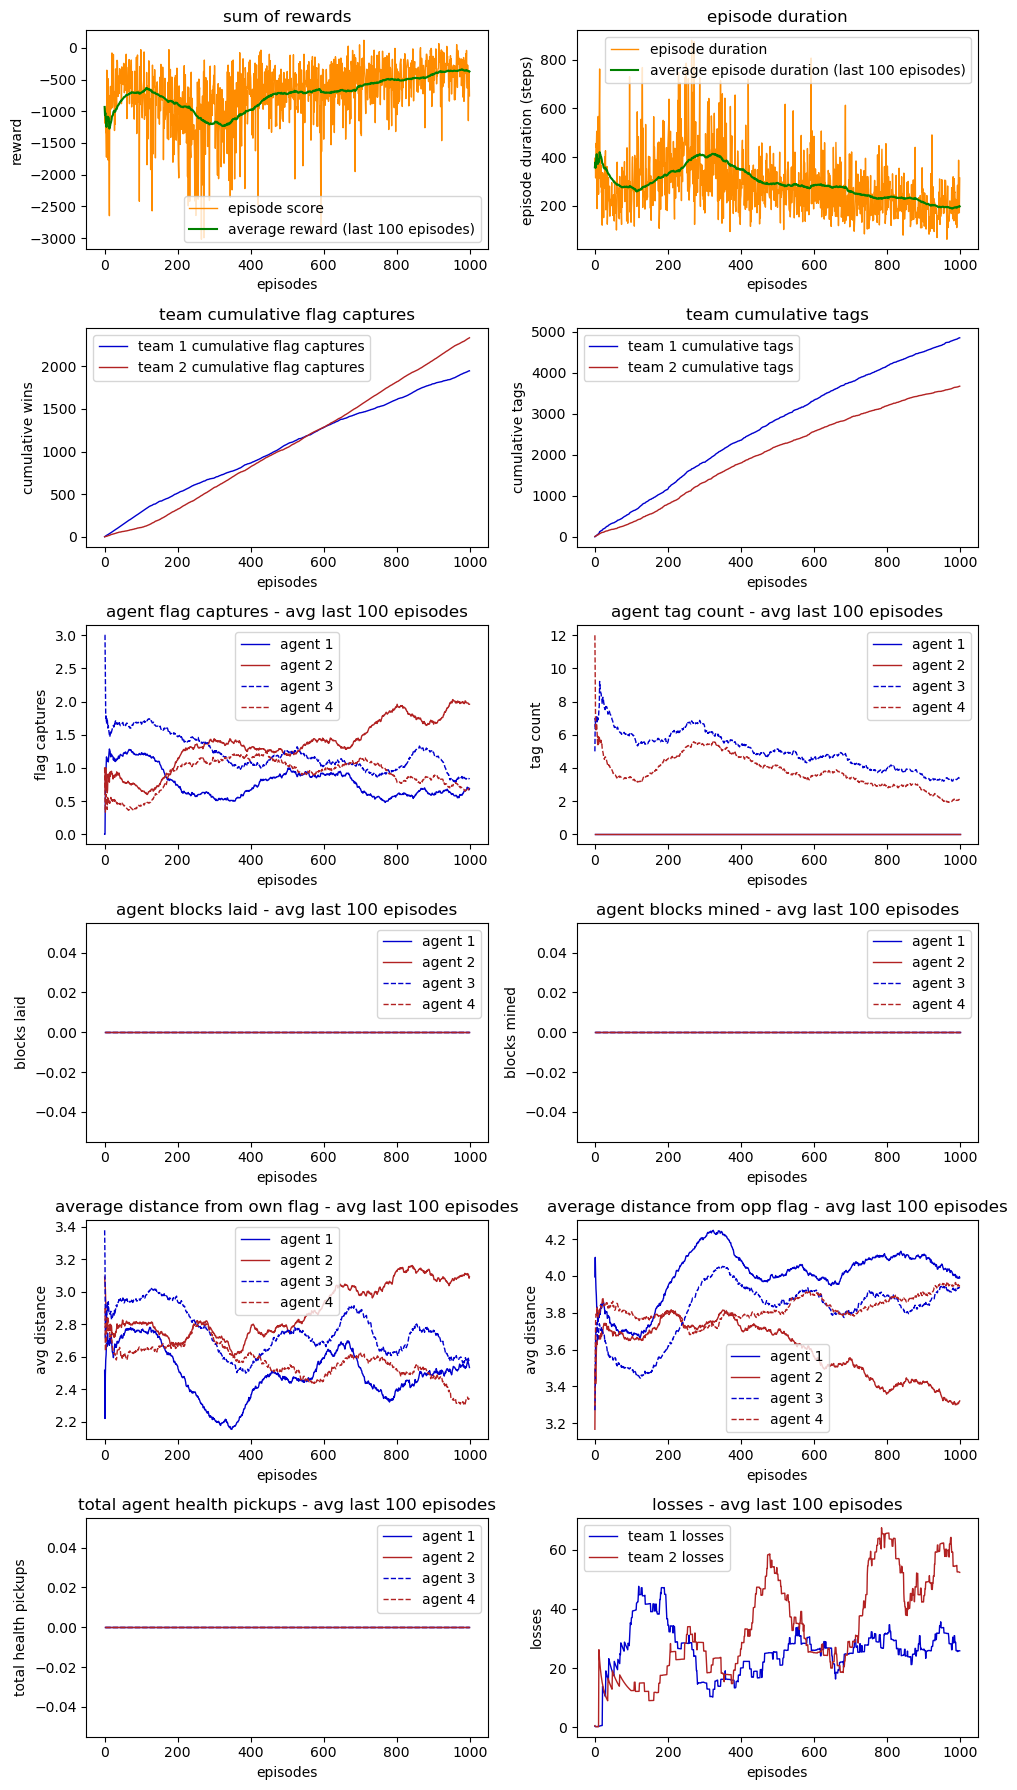

In [20]:
ut.plot_training_performance(training_metrics)

#### Inference

In [8]:
# create agents
use_softmax = True
agent_t1 = DQNAgent(name='dqn_t1',
                      use_softmax=use_softmax)

agent_t2 = DQNAgent(name='dqn_t2',
                      use_softmax=use_softmax)


In [17]:
# create environment
env = GridworldCtf(GAME_MODE='static',
                   GRID_LEN=6,
                   N_AGENTS=2)
                   

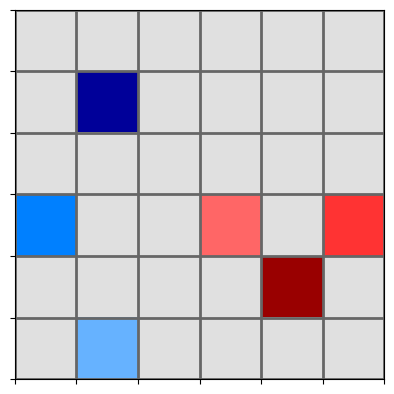

Game won!                       
Final score: 152                       
Team 1 score: 0                       
Team 2 score: 3                       
Total moves: 37


In [12]:
# test model
# env_dims = (1, 1, 6, 6)
ut.test_model(env, 
             agent_t1, 
             agent_t2, 
             display=True, 
             max_moves=100,
             use_ego_state=False,
             scale_tiles=False)

### Train with standardised state

In [ ]:
# create environment
env = GridworldCtf(GAME_MODE='static',
                   GRID_LEN=6,
                   N_AGENTS=4)
device = "cpu"

# configure agents
n_actions = 8
n_channels = 1
batch_size = 32
gamma = 0.9
lr = 0.00005
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
use_softmax = True
loss = 'mse'

agent_t1 = DQNAgent(name='dqn_t1',
                    grid_len=env.EGO_GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

agent_t2 = DQNAgent(name='dqn_t2',
                    grid_len=env.EGO_GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

# train agents
training_metrics = tdqn.train_dqn(env,
                                agent_t1,
                                agent_t2,
                                epochs=1000,
                                batch_size=batch_size,
                                epsilon=epsilon,
                                epsilon_decay=0.999,
                                epsilon_min=0.1,
                                n_random_steps=0,
                                max_steps=1000,
                                learning_skip_steps=1,
                                use_ego_state=True,
                                scale_tiles=False,
                                device=device)

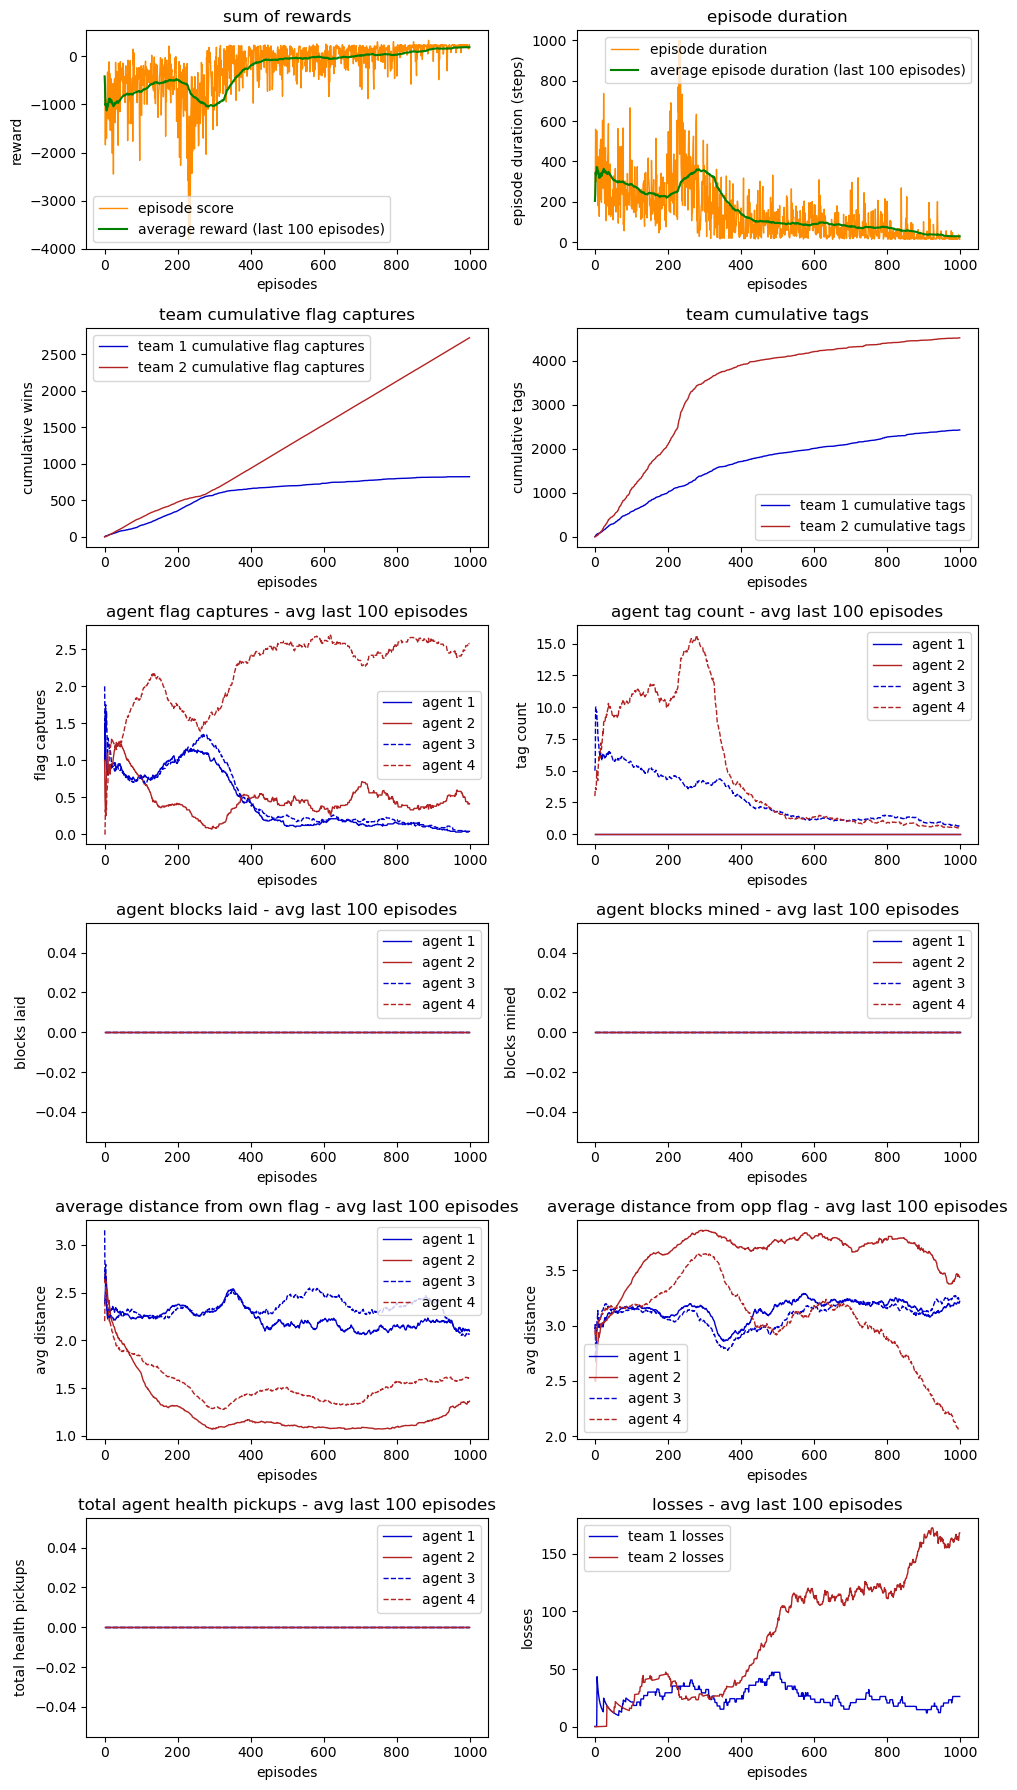

In [15]:
ut.plot_training_performance(training_metrics)

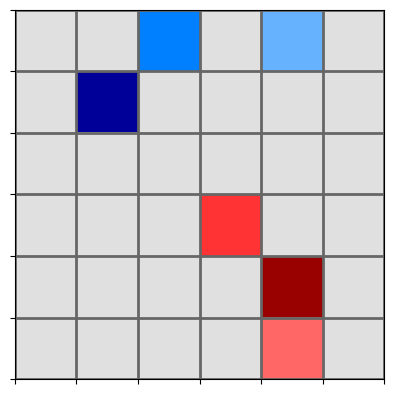

Game won!                       
Final score: 224                       
Team 1 score: 0                       
Team 2 score: 3                       
Total moves: 19


In [18]:
ut.test_model(env, 
             agent_t1, 
             agent_t2, 
             display=True, 
             max_moves=100,
             use_ego_state=True,
             scale_tiles=False)

#### Interactive play with trained agents

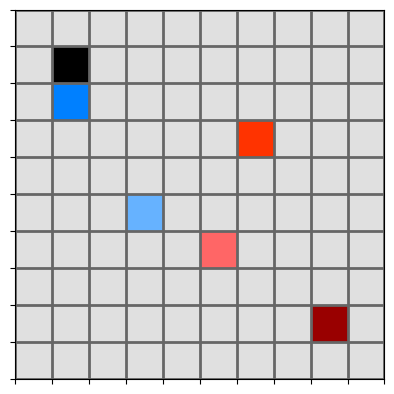

You win!, total score 141


In [12]:
env = GridworldCtf(game_mode='static')
env.play(player=0, agents=agents)

## Independent Proximal Policy Optimisation (IPPO)

In [2]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
from dueling_dqn_network import DuelingDQNNetwork
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
import utils as ut
import train_dqn as tdqn

from ppo import PPOMemory, ActorNetwork, CriticNetwork, PPOAgent
import train_ppo as tppo
import train_ppo_universal as tppou

In [2]:
env = GridworldCtf(GAME_MODE='random',
                    GRID_LEN=6,
                    AGENT_CONFIG = {
                    0: {'team':0, 'type':0},
                    1: {'team':1, 'type':0},
                    2: {'team':0, 'type':0},
                    3: {'team':1, 'type':0}
                })


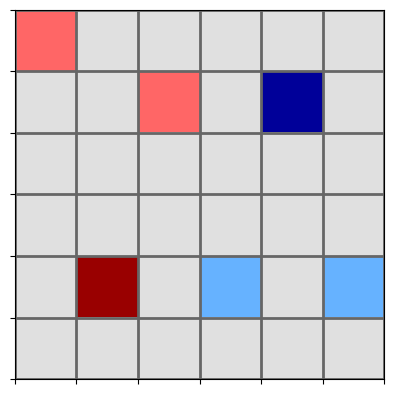

In [4]:
env.render()

In [3]:
env = GridworldCtf(GAME_MODE='random',
                    GRID_LEN=6,
                    AGENT_CONFIG = {
                    0: {'team':0, 'type':0},
                    1: {'team':1, 'type':0},
                    2: {'team':0, 'type':0},
                    3: {'team':1, 'type':0}
                })
n_actions = 8
n_episodes = 1
learning_steps = 20
max_steps = 1000
batch_size = 32
n_epochs = 4
alpha = 0.000015
policy_clip = 0.1
softmax_temp = 0.9
use_ego_state = True
if use_ego_state:
    grid_len = env.EGO_GRID_LEN
else:
    grid_len = env.GRID_LEN

agent_t1 = PPOAgent(n_actions=n_actions, 
                    batch_size=batch_size, 
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs,
                    grid_len=grid_len,
                    softmax_temp=softmax_temp)

agent_t2 = PPOAgent(n_actions=n_actions, 
                    batch_size=batch_size, 
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs, 
                    grid_len=grid_len,
                    softmax_temp=softmax_temp)    

training_metrics = tppo.train_ppo(env,
                        agent_t1,
                        agent_t2,
                        n_episodes,
                        learning_steps=learning_steps,
                        max_steps=max_steps,
                        use_ego_state=use_ego_state,
                        device='cpu')
    

Network convolutional layer dimensions
Conv 1 output dim: 9 x 9
Conv 2 output dim: 8 x 8
Conv 3 output dim: 7 x 7
Conv 3 unrolled output shape: 588

Network convolutional layer dimensions
Conv 1 output dim: 9 x 9
Conv 2 output dim: 8 x 8
Conv 3 output dim: 7 x 7
Conv 3 unrolled output shape: 588

Network convolutional layer dimensions
Conv 1 output dim: 9 x 9
Conv 2 output dim: 8 x 8
Conv 3 output dim: 7 x 7
Conv 3 unrolled output shape: 588

Network convolutional layer dimensions
Conv 1 output dim: 9 x 9
Conv 2 output dim: 8 x 8
Conv 3 output dim: 7 x 7
Conv 3 unrolled output shape: 588



TypeError: GridworldCtf.standardise_state() got an unexpected keyword argument 'scale_tiles'

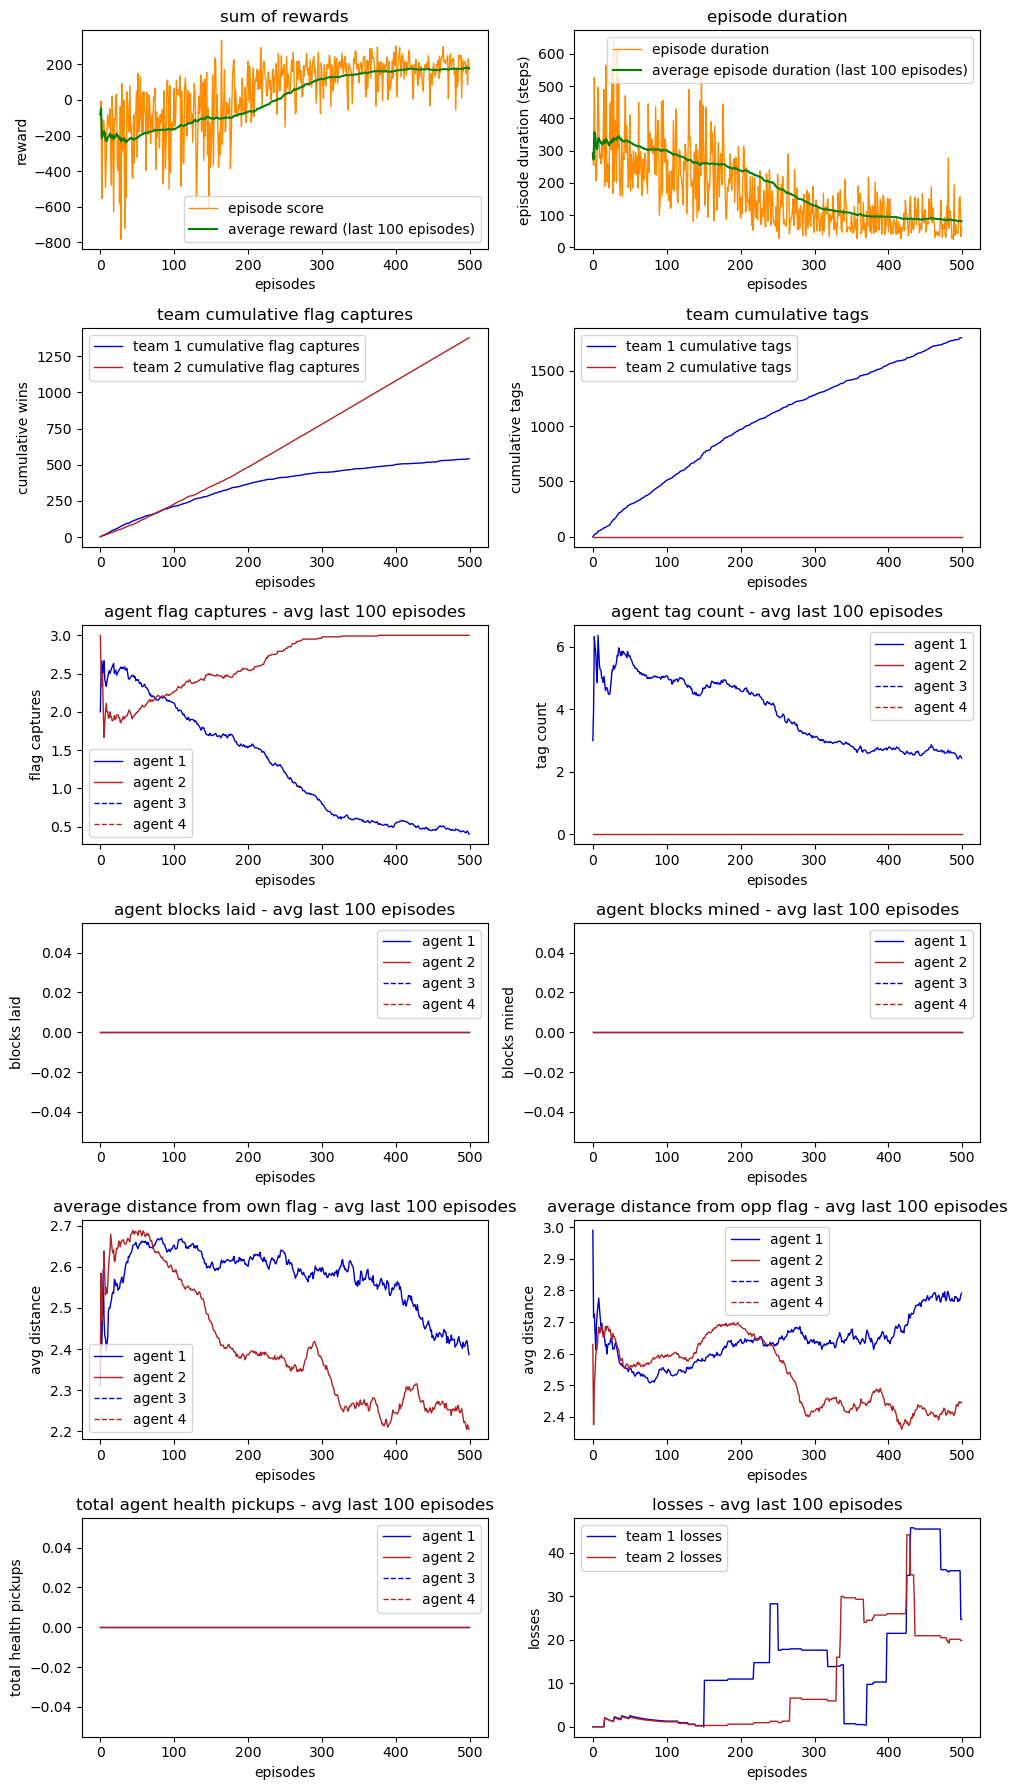

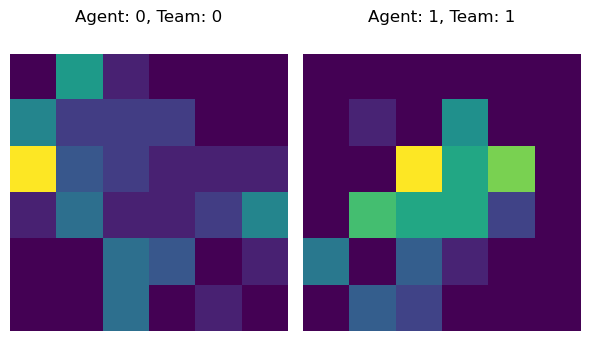

In [17]:
ut.plot_training_performance(training_metrics)
ut.plot_visitation_maps(env)

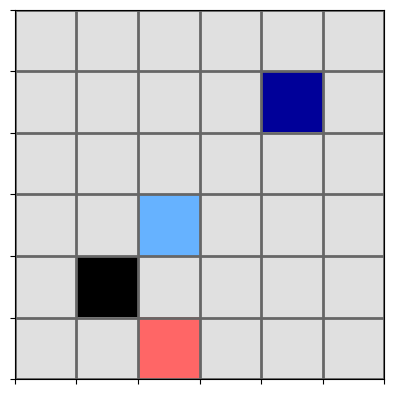

Game won!                       
Final score: 122                       
Team 1 score: 0                       
Team 2 score: 3                       
Total moves: 89


In [18]:
ut.test_model_ppo(env, 
                agent_t1, 
                agent_t2, 
                display=True, 
                use_ego_state=True,
                scale_tiles=False,
                max_moves=100, 
                device='cpu')

### Multi-Agent Proximal Policy Optimisation (MAPPO)

In [31]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
from dueling_dqn_network import DuelingDQNNetwork
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
import utils as ut
import train_dqn as tdqn

from mappo import PPOMemory, ActorNetwork, CriticNetwork, PPOAgent
import train_mappo as tppo_mappo

In [30]:
env = GridworldCtf(GAME_MODE='random',
                    GRID_LEN=6,
                    AGENT_CONFIG = {
                    0: {'team':0, 'type':0},
                    1: {'team':1, 'type':0},
                    },
                    DROP_FLAG_WHEN_NO_HP=False,
                    GLOBAL_REWARDS=False)

n_actions = 8
n_episodes = 1000
learning_steps = 1000
max_steps = 1000
batch_size = 256
n_epochs = 5
alpha = 0.0003
policy_clip = 0.2
softmax_temp = 0.9
use_ego_state = True
if use_ego_state:
    grid_len = env.EGO_GRID_LEN
else:
    grid_len = env.GRID_LEN
actor_metadata_len = env.get_env_metadata_local(0).shape[0]
critic_metadata_len = env.get_env_metadata_global([0, 0]).shape[0]
verbose_episodes = 1

agent_t1 = PPOAgent(n_actions=n_actions, 
                    actor_grid_len=env.GRID_LEN,
                    critic_grid_len=env.GRID_LEN,
                    actor_metadata_len=actor_metadata_len,
                    critic_metadata_len=critic_metadata_len,
                    batch_size=batch_size,
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs,
                    softmax_temp=softmax_temp)

agent_t2 = PPOAgent(n_actions=n_actions, 
                    actor_grid_len=env.GRID_LEN,
                    critic_grid_len=env.GRID_LEN,
                    actor_metadata_len=actor_metadata_len,
                    critic_metadata_len=critic_metadata_len,
                    batch_size=batch_size,
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs,
                    softmax_temp=softmax_temp)
  
training_metrics = tppo_mappo.train_ppo(env,
                        agent_t1,
                        agent_t2,
                        n_episodes,
                        learning_steps=learning_steps,
                        max_steps=max_steps,
                        use_ego_state=use_ego_state,
                        verbose_episodes=verbose_episodes,
                        device='cpu')
    

episode: 1000                 
total step count: 145384                 
episode step count: 68                 
score: 264                 
average score: 199.36                 
done count: 1000                 
team 1 captures: 905                 
team 2 captures: 2732                 
agent actions: [7, 7]                 
rewards: [-1, 99]


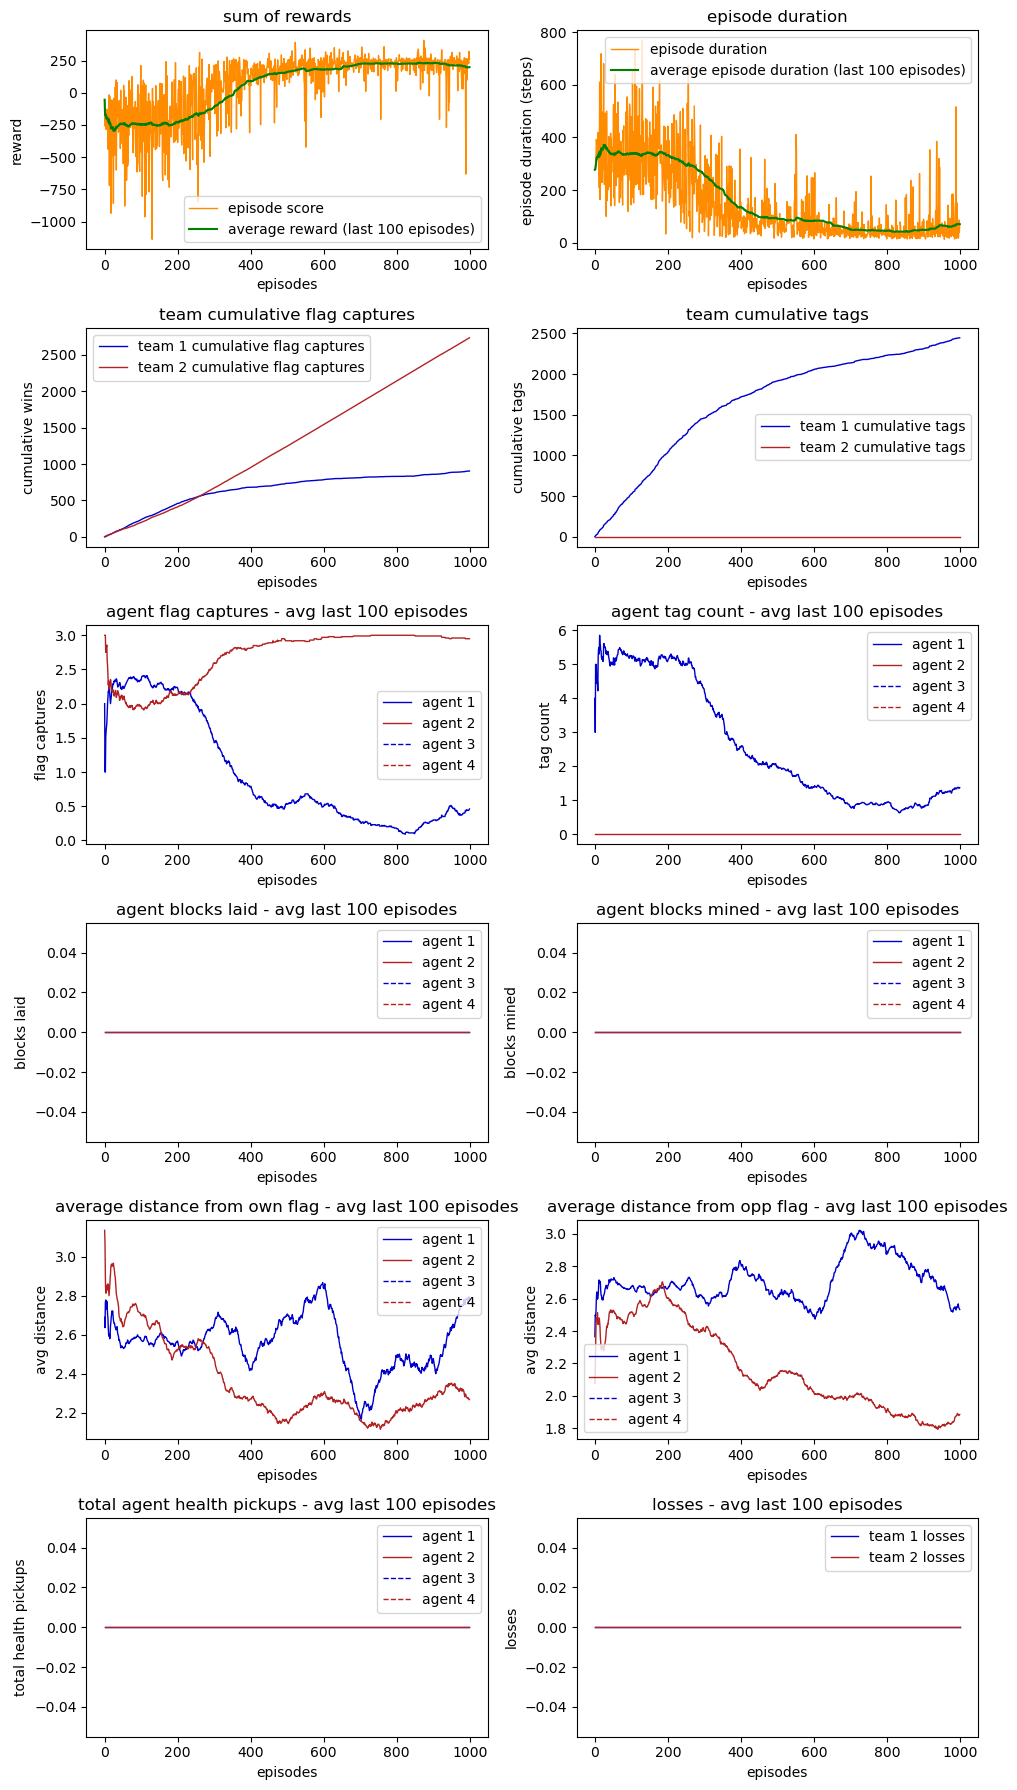

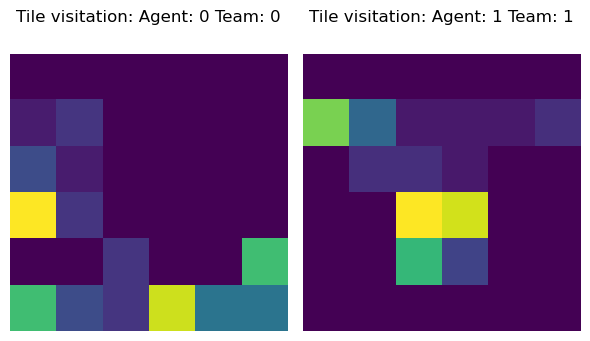

In [32]:
ut.plot_training_performance(training_metrics)
ut.plot_visitation_maps(env)

In [26]:
ut.test_model_mappo(env, 
                    agent_t1,
                    agent_t2, 
                    display=True, 
                    use_ego_state=True,
                    max_moves=50, 
                    device='cpu')

ValueError: cannot reshape array of size 180 into shape (1,5,11,11)

In [33]:

def test_model_mappo(env, 
                agent_t1, 
                agent_t2, 
                display=True, 
                use_ego_state=True,
                max_moves=50, 
                device='cpu'):
    """
    Test the trained agent policies.
    """
    env.reset()

    done = False
    step_count = 0
    score = 0

    if use_ego_state:
        env_dims = env.EGO_ENV_DIMS
    else:
        env_dims = env.ENV_DIMS

    #TEMP: hardcoded env dims
    env_dims = (1, 5, 6, 6)

    while not done: 
        step_count += 1

        # Collect actions for each agent
        actions =[]
        for agent_idx in np.arange(env.N_AGENTS):
            metadata_state_local_ = env.get_env_metadata_local(agent_idx)
            metadata_state_local = torch.from_numpy(metadata_state_local_).reshape(1, metadata_state_local_.shape[0]).float().to(device)
                
            # Get global and local states
            grid_state_local_ = env.standardise_state(agent_idx, use_ego_state=use_ego_state).reshape(*env_dims) #+ ut.add_noise(env_dims)
            grid_state_local = torch.from_numpy(grid_state_local_).float().to(device)

            if env.AGENT_TEAMS[agent_idx]==0:
                action, _, = agent_t1.choose_action(grid_state_local, metadata_state_local)
                actions.append(action)
            else:
                action, _, = agent_t2.choose_action(grid_state_local, metadata_state_local)
                actions.append(action)

        # Step the environment
        _, rewards, done = env.step(actions)

        # Increment score
        score += sum(rewards)

        if display:
            env.render(sleep_time=0.1)

        if done:
            if display:
                print(f"Game won! \
                      \nFinal score: {score} \
                      \nTeam 1 score: {env.metrics['team_points'][0]} \
                      \nTeam 2 score: {env.metrics['team_points'][1]} \
                      \nTotal moves: {step_count}")
       
        if (step_count > max_moves):
            if display:
                print(f"Move limit reached. \
                      \nFinal score: {score} \
                      \nTeam 1 score: {env.metrics['team_points'][0]} \
                      \nTeam 2 score: {env.metrics['team_points'][1]} \
                      \nTotal moves: {step_count}")
            break

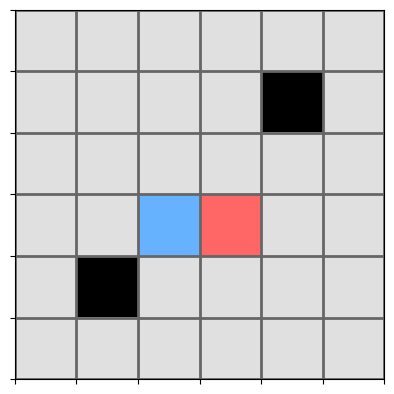

Move limit reached.                       
Final score: -2                       
Team 1 score: 0                       
Team 2 score: 1                       
Total moves: 51


In [34]:
test_model_mappo(env, 
                    agent_t1,
                    agent_t2, 
                    display=True, 
                    use_ego_state=True,
                    max_moves=50, 
                    device='cpu')

### Multi-agent

In [37]:
env = GridworldCtf(GAME_MODE='random',
                    GRID_LEN=6,
                    AGENT_CONFIG = {
                        0: {'team':0, 'type':0},
                        1: {'team':1, 'type':0},
                        2: {'team':0, 'type':0},
                        3: {'team':1, 'type':0}
                    },
                    DROP_FLAG_WHEN_NO_HP=False,
                    GLOBAL_REWARDS=False)

n_actions = 8
n_episodes = 1000
learning_steps = 1000
max_steps = 1000
batch_size = 256
n_epochs = 5
alpha = 0.0003
policy_clip = 0.1
softmax_temp = 0.9
use_ego_state = True
if use_ego_state:
    grid_len = env.EGO_GRID_LEN
else:
    grid_len = env.GRID_LEN
actor_metadata_len = env.get_env_metadata_local(0).shape[0]
critic_metadata_len = env.get_env_metadata_global([0, 0]).shape[0]
verbose_episodes = 1

agent_t1 = PPOAgent(n_actions=n_actions, 
                    actor_grid_len=env.GRID_LEN,
                    critic_grid_len=env.GRID_LEN,
                    actor_metadata_len=actor_metadata_len,
                    critic_metadata_len=critic_metadata_len,
                    batch_size=batch_size,
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs,
                    softmax_temp=softmax_temp)

agent_t2 = PPOAgent(n_actions=n_actions, 
                    actor_grid_len=env.GRID_LEN,
                    critic_grid_len=env.GRID_LEN,
                    actor_metadata_len=actor_metadata_len,
                    critic_metadata_len=critic_metadata_len,
                    batch_size=batch_size,
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs,
                    softmax_temp=softmax_temp)
  
training_metrics = tppo_mappo.train_ppo(env,
                        agent_t1,
                        agent_t2,
                        n_episodes,
                        learning_steps=learning_steps,
                        max_steps=max_steps,
                        use_ego_state=use_ego_state,
                        verbose_episodes=verbose_episodes,
                        device='cpu')
    

episode: 1000                 
total step count: 157712                 
episode step count: 25                 
score: 200                 
average score: -46.72                 
done count: 1000                 
team 1 captures: 1704                 
team 2 captures: 2396                 
agent actions: [7, 7, 4, 4]                 
rewards: [-1, -1, -1, 99]


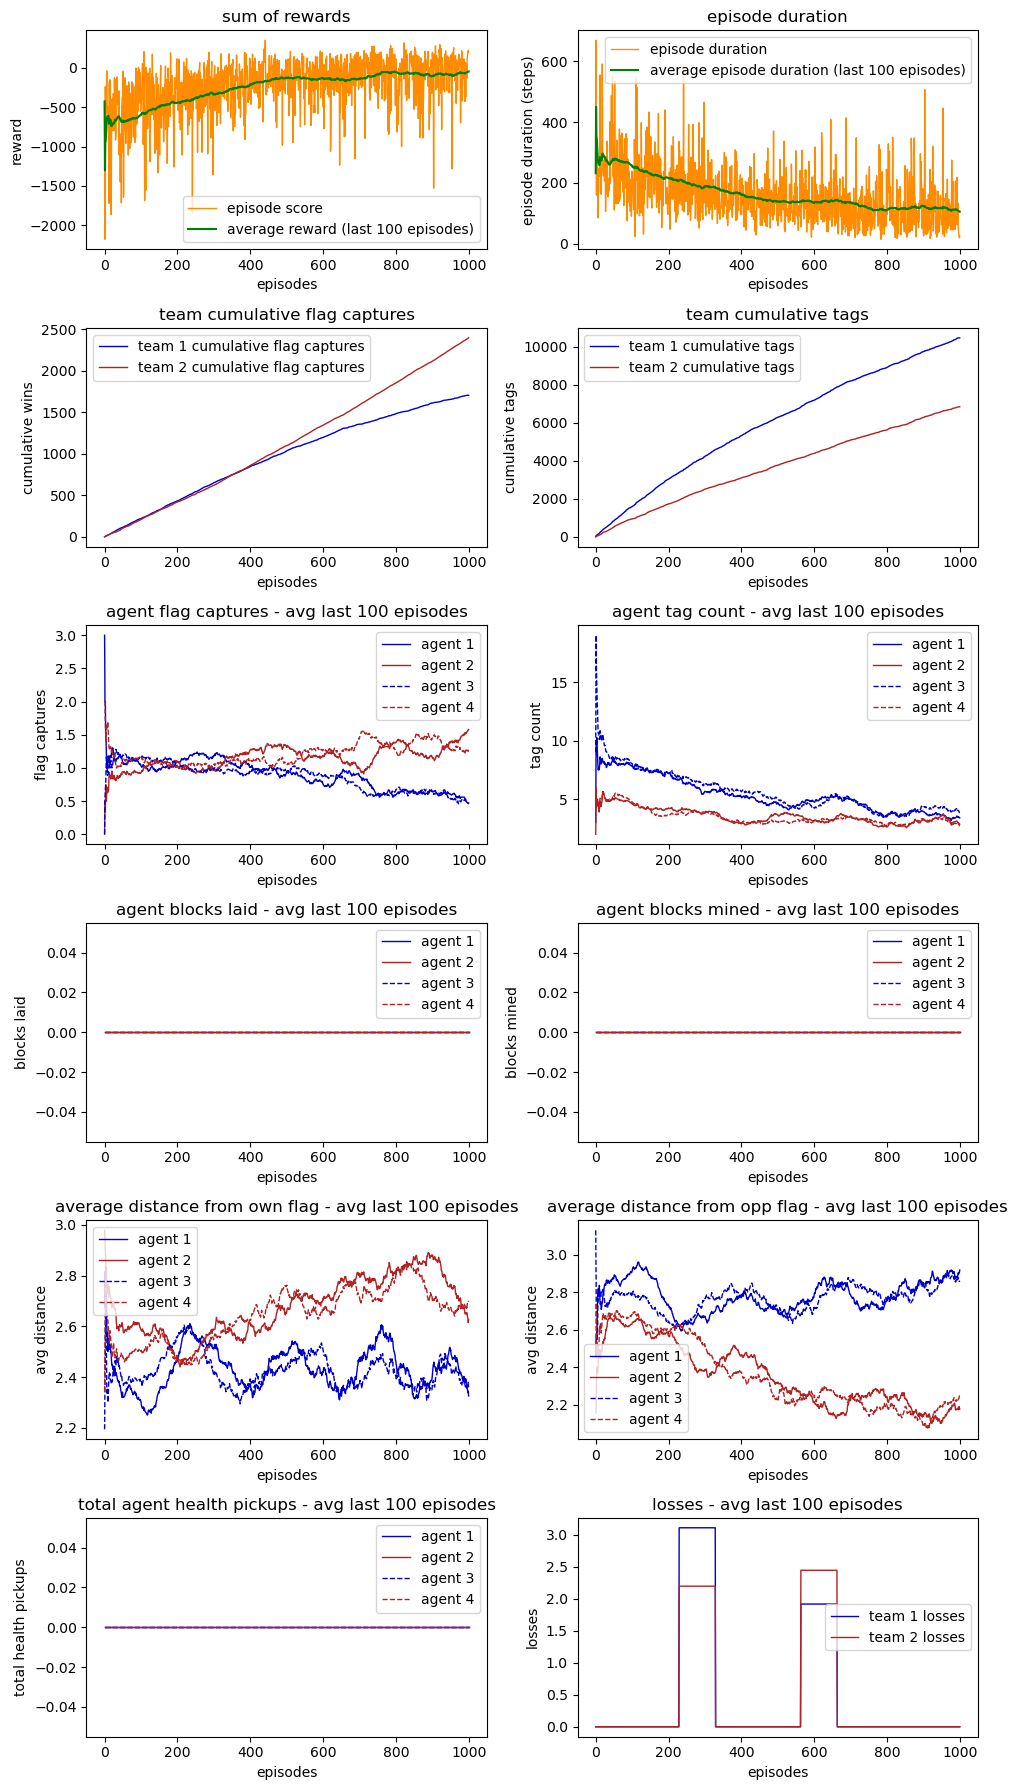

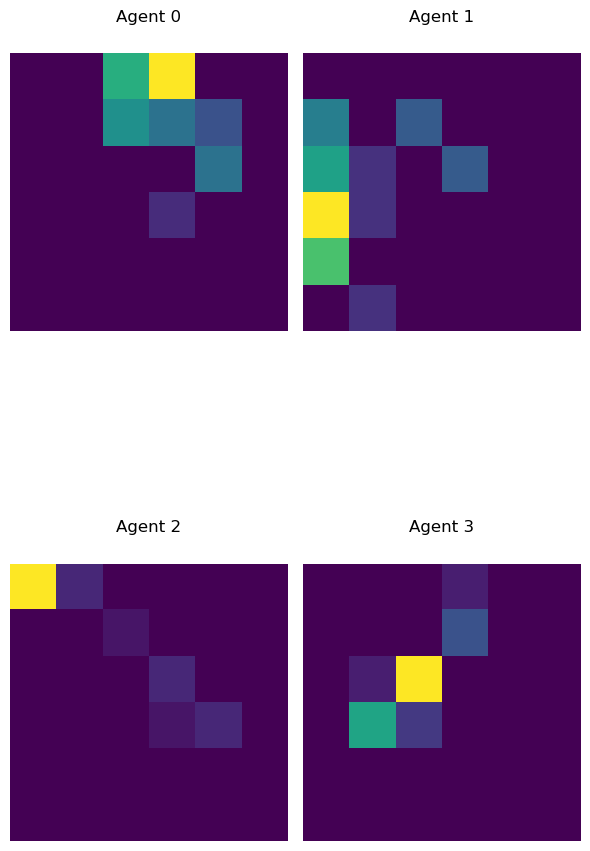

In [38]:
ut.plot_training_performance(training_metrics)
ut.plot_visitation_maps(env)

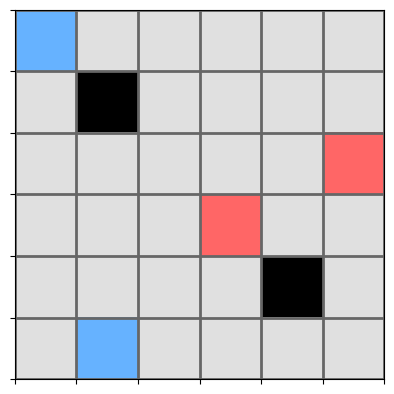

Move limit reached.                       
Final score: -104                       
Team 1 score: 0                       
Team 2 score: 1                       
Total moves: 51


In [39]:
test_model_mappo(env, 
                    agent_t1,
                    agent_t2, 
                    display=True, 
                    use_ego_state=True,
                    max_moves=50, 
                    device='cpu')